In [1]:
import os
os.chdir("../")
os.getcwd()

'/home/bbd0953/diffusion/src'

# Model Evaluation

# Training Loss

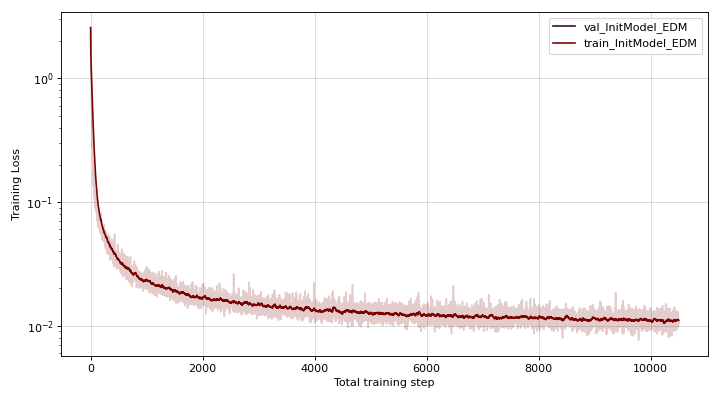

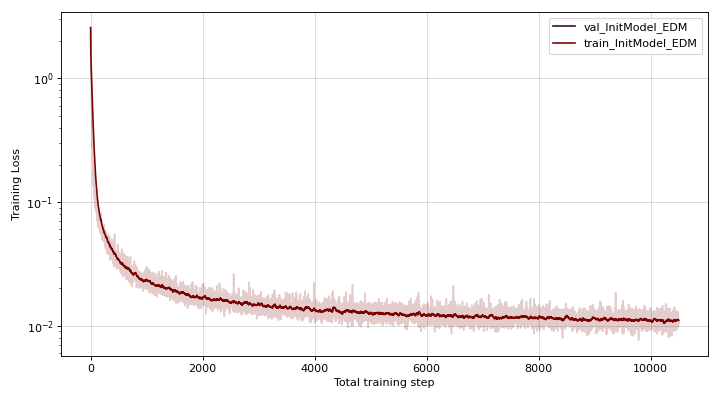

In [5]:
from pathlib import Path
import sys
from importlib import reload
reload(sys.modules['utils.plot_utils'])
from utils.plot_utils import plot_losses, add_loss_plot
import matplotlib as mpl
import numpy as np
model_dir = Path("/home/bbd0953/diffusion/results/InitModel_EDM")
loss_files = list(model_dir.glob("losses*.csv"))
%matplotlib widget
fig, ax = plot_losses(loss_files, smooth=50)
fig.show()

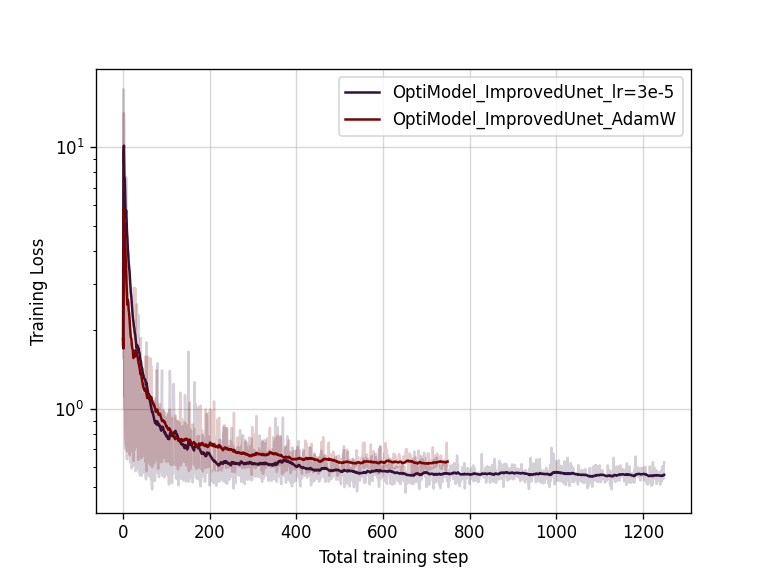

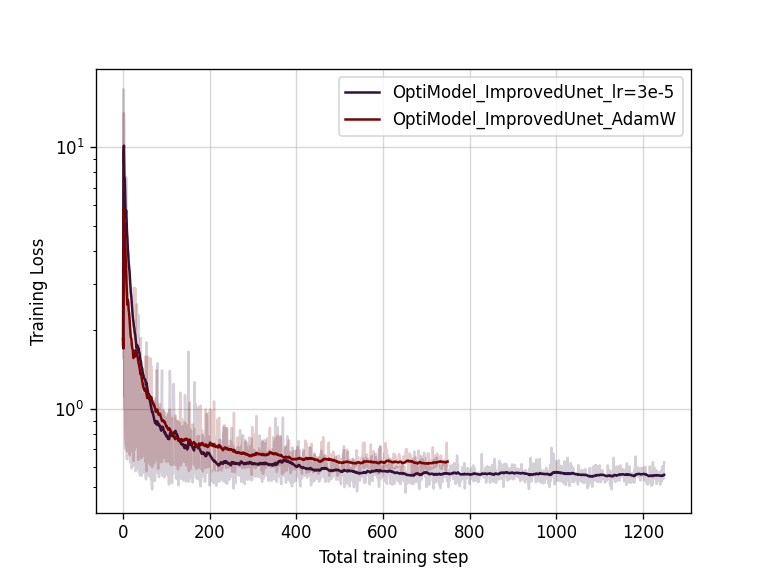

In [6]:
from pathlib import Path
from model.utils import plot_losses

results_dir = Path("results")
models = [
    "OptiModel_ImprovedUnet_lr=3e-5",
    "OptiModel_ImprovedUnet_AdamW",
]
loss_files = [results_dir / f"{model}/losses_{model}.csv" for model in models]

%matplotlib widget
fig, ax = plot_losses(loss_files, smooth=50)
fig.show()

['Dropout=0.10', 'Dropout=0.15', 'Dropout=0.05', 'Dropout=0.20', 'Dropout=0.30', 'Dropout=0.40']


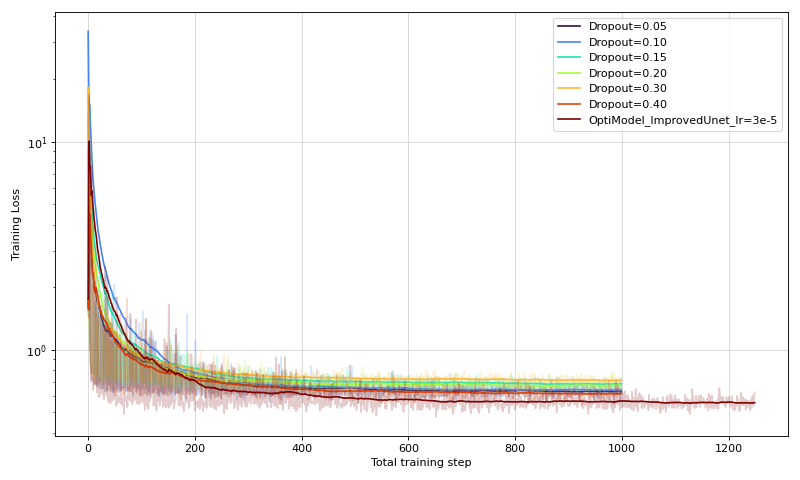

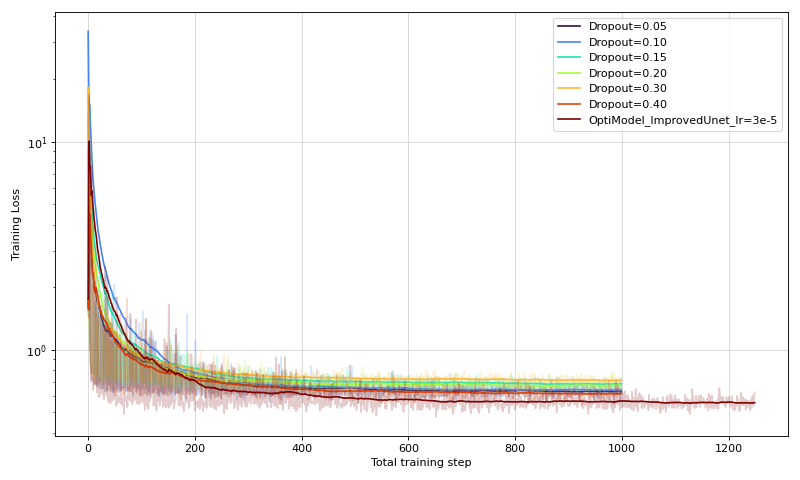

In [3]:
from pathlib import Path
from model.utils import plot_losses, add_loss_plot
import matplotlib as mpl
import numpy as np
results_dir = Path("results/dropout_rates")
models = [
    f.name for f in results_dir.iterdir() if f.is_dir()
]
print(models)

loss_files = sorted(
    [results_dir / f"{model}/losses_{model}.csv" for model in models]
)

# Model without dropout
loss_files.append(
    Path('results/learning_rates/OptiModel_ImprovedUnet_lr=3e-5/' \
         'losses_OptiModel_ImprovedUnet_lr=3e-5.csv')
)

%matplotlib widget
fig, ax = plot_losses(loss_files, smooth=100)
fig.show()

# Sampling

In [2]:
from diffusion import Diffusion
from unet import Unet
import torch
import numpy as np
from utils import plot_samples

def plot_samples(imgs, title=None):
    n = int(np.sqrt(imgs.shape[0]))
    fig, axs = plt.subplots(nrows=n, ncols=n, tight_layout=True,
                            figsize=(12,12))
    for ax, img in zip(axs.flat, imgs):
        ax.axis('off')
        ax.imshow(img.squeeze(), vmin=-1, vmax=1)

    if title is not None:
        fig.suptitle(title, fontsize='xx-large')

    return fig, axs

def generate_examples(
        model_file,
        timesteps,
        schedule,
        learn_variance,
        n_samples=16):
    diffusion = Diffusion(
        Unet,
        timesteps=timesteps,
        schedule=schedule,
        learn_variance=learn_variance)
    model.load_state_dict(torch.load(model_file))
    model.eval()
    model.cuda()
    with torch.no_grad():
        samples = model.sample(n_samples).cpu().numpy()
    return samples

In [16]:

model_file = "/home/bbd0953/diffusion/results/DDPM_23-09-01_08:03:11.pt"
ema_file = "/home/bbd0953/diffusion/results/DDPM_23-09-01_08:03:11_EMA.pt"

bsize = 36  # Should have integer square root

model = Unet(dim=160, image_channels=1, channel_mults=(1, 2, 3, 4)).to('cuda:1')
model.load_state_dict(torch.load(model_file))

diffusion = Diffusion(timesteps=1000)

imgs = diffusion.sample(model, 80, batch_size=bsize)[-1]  # Only last time step

model.load_state_dict(torch.load(ema_file))
imgs_ema = diffusion.sample(model, 80, batch_size=bsize)[-1]

model = model.to('cpu');

Sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

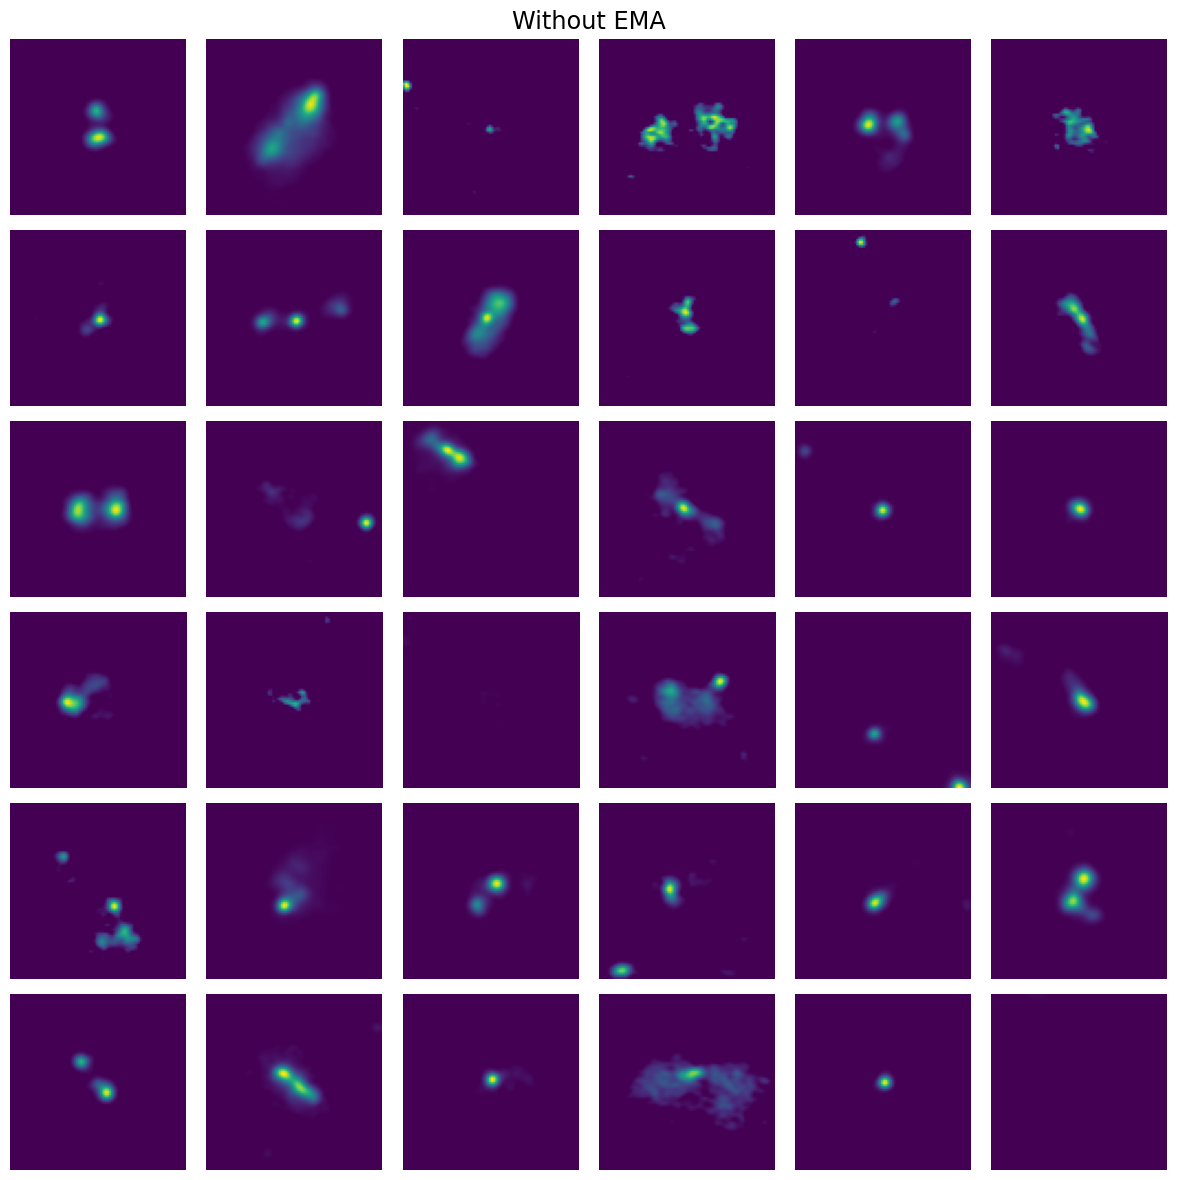

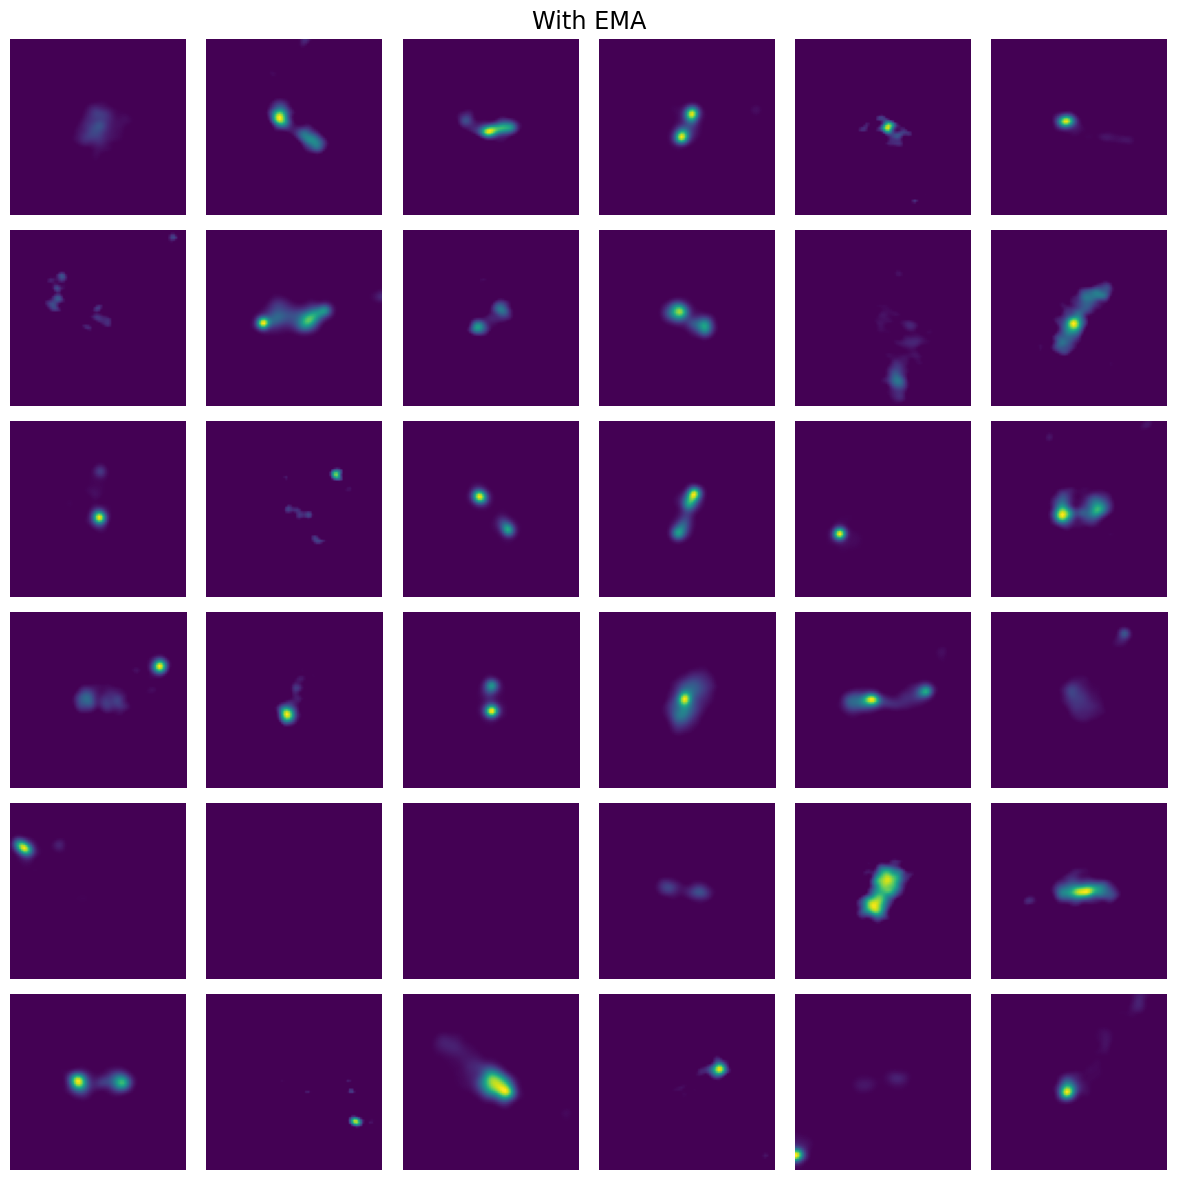

In [20]:
plot_samples(imgs, title="Without EMA")
plot_samples(imgs_ema, title="With EMA");

# Existing Data

## Real Data

Loading images...


100%|██████████| 84411/84411 [00:02<00:00, 35935.41it/s]


Data set initialized.


(<Figure size 1200x1200 with 25 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

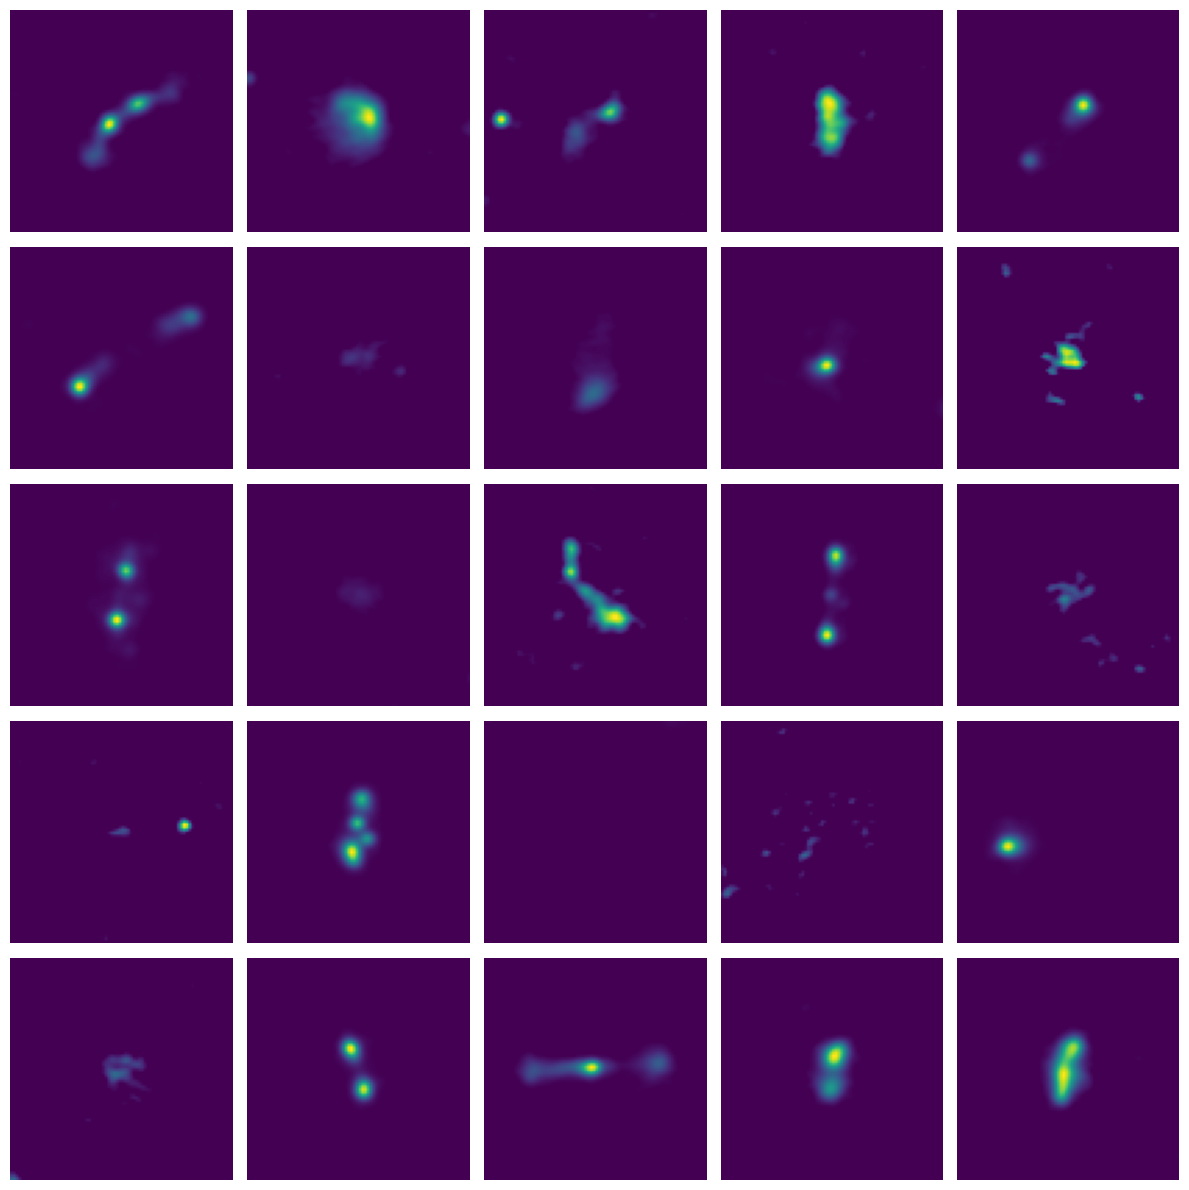

In [4]:
from lofar_data import LofarUnlabeled
from utils import plot_samples
from torchvision.transforms import ToTensor, Compose, CenterCrop
from torch.utils.data import DataLoader

transform = Compose([
        ToTensor(),
        CenterCrop(80),
        lambda x: x * 2 - 1,  # Scale to [-1, 1]
    ])

data = LofarUnlabeled(root="./data", transform=transform,
                        las_thr=[40, 120], flux_thr=5)
dataloader = DataLoader(data, shuffle=True, batch_size=25)

batch = next(iter(dataloader))
plot_samples(batch)

## Generated Data

In [3]:
import torch
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, CenterCrop
from model.utils import plot_samples
from model.utils import clip_and_rescale

class ImagePathDataset(torch.utils.data.Dataset):
    # From:
    #  https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py
    def __init__(self, path, transforms=None):
        self.path = path
        self.files = sorted(self.path.iterdir())
        self.transforms = transforms

        print("Loading images...")
        load = lambda f: Image.open(f)
        self.data = list(map(load, tqdm(self.files)))

        print("Data set initialized.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        img = self.data[i]
        if self.transforms is not None:
            img = self.transforms(img)
        return img


In [63]:
lofar_img_path = Path("./data/images-lofar_unlabeled")

files = sorted([file for file in lofar_img_path.glob("*")])
f = files[0]
f

PosixPath('data/images-lofar_unlabeled/annotation-lofar_unlabeled.csv')

In [15]:
gen_path = Path("./data/generated/diffusion_v1.0_DDIM")

transform = Compose([
        ToTensor(),
        CenterCrop(80),
        lambda img: img[:1,:,:],  # First channel only
        # lambda img: clip_and_rescale(img)
    ])
gen_data = ImagePathDataset(gen_path, transforms=transform)

Loading images...


100%|██████████| 13500/13500 [00:01<00:00, 13002.36it/s]

Data set initialized.


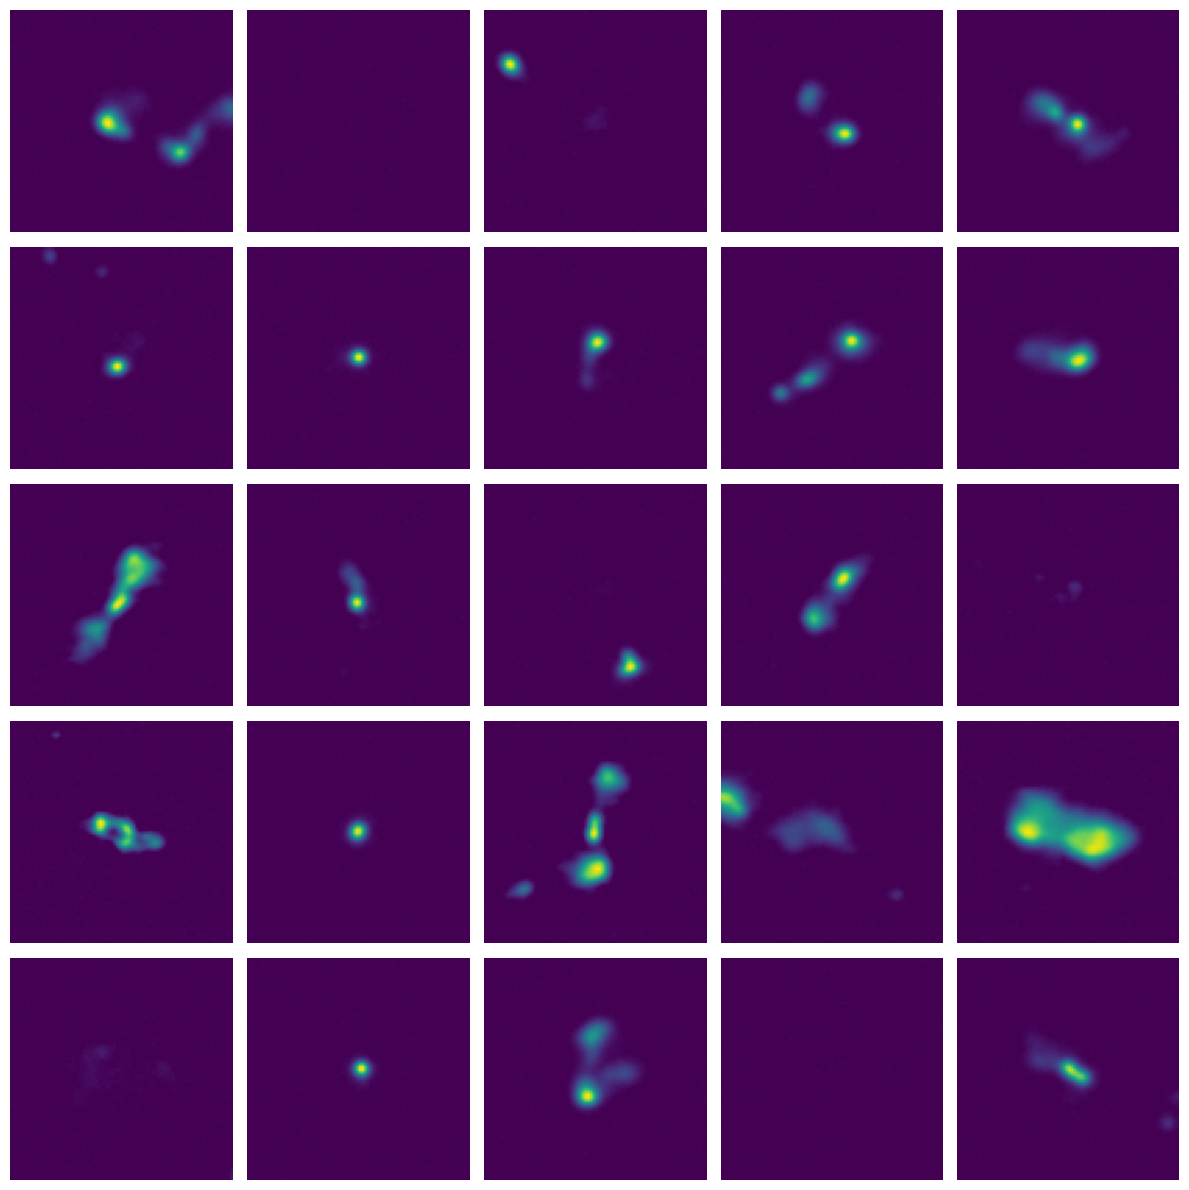

In [16]:
gen_dl = DataLoader(gen_data, batch_size=25, shuffle=True)

batch = next(iter(gen_dl))
plot_samples(batch, vmin=0);